# Árboles de decisión

Los árboles de decisión son métodos de aprendizaje de máquinas muy utilizados debido a su buen rendimiento y su explicabilidad. Un árbol de decisión no siempre tiene buen rendimiento, por lo que se proponen técnicas de ensamble de árboles de decisión aislados para generar un estimador más robusto que el estimador único por el que está conformado el ensamble.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.tree # Árboles de decisión
import sklearn.ensemble # Ensambles de modelos
import sklearn.model_selection

Utilizaremos un conjunto de datos de predicción de diabetes dado una serie de parámetros fisiológicos de un paciente.

In [2]:
diabetes = pd.read_csv("data/diabetes.csv")

In [3]:
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Para ilustrar la construcción de un árbol de decisión utilizaremos sólo un par de variables del conjunto de datos.

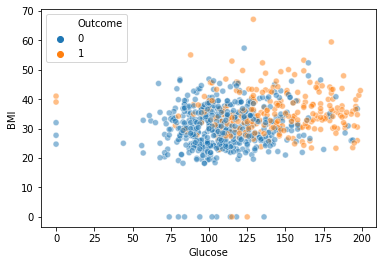

In [4]:
sns.scatterplot(
    data = diabetes,
    x = "Glucose",
    y = "BMI",
    hue = "Outcome",
    alpha = 0.5
)

# Árbol de decisión

Para la construcción de un árbol de decisión, primero debemos definir una métrica a optimizar. En el caso de los árboles de decisión, una métrica que podemos optimizar es la entropía. En donde a medida que vamos tomando decisiones buscamos ganar información o disminuir la entropía.

La definición de entropía que utilizaremos es la siguiente:

$$
H(X)=- \sum_{i}p(x_i) \log_2 p(x_i)
$$

Donde $X$ es el conjunto de etiquetas.

In [5]:
def entropy(data):
    classes = np.unique(data)
    entropies = []
    for c in classes:
        p = sum(data == c) / len(data)
        current_entropy = p * np.log2(p)
        entropies.append(current_entropy)
    return -1 * sum(entropies)

Para comenzar, podemos estimar la entropía total del conjunto de datos

In [6]:
entropy(diabetes.Outcome)

0.9331343166407831

Ahora, debemos tomar una decisión, con la cual buscamos disminuir la entropía de cada uno de los subconjuntos obtenidos posterior a la decisión.

In [7]:
entropy(diabetes.Outcome[diabetes.Glucose >= 175])

0.6699960320994333

In [8]:
entropy(diabetes.Outcome[diabetes.Glucose < 175])

0.8941290186253703

Para estimar la entropía general de la decisión que tomamos debemos calcular un promedio ponderado de cada una de las entropías de cada subconjunto de datos.

In [9]:
def weighted_entropy(data, feature, label, threshold):
    indices = data[feature] >= threshold
    entropy_0 = entropy(data[label][indices])
    entropy_1 = entropy(data[label][~indices])
    return entropy_0 * (sum(indices) / len(indices)) + entropy_1 * (sum(~indices) / len(indices))


In [10]:
weighted_entropy(diabetes, "Glucose", "Outcome", 175)

0.8774941485316484

Para determinar la mejor variable y el mejor umbral para la decisión del nodo del árbol debemos optimizar la ganancia de información de la decisión con la siguiente definición:

$$
IG(Y,X) = E(Y) - E(Y|X)
$$

Donde a la entropía total del conjunto de datos $E(Y)$ le restamos la entropía promedio $E(Y|X)$ de la decisión $Y$.

In [11]:
entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", 175)

0.055640168109134636

Calculamos las entropías asociadas a un barrido de umbrales en un par de variables.

In [12]:
glucose_information_gain_sweep = []
glucose_thresholds = np.linspace(diabetes.Glucose.min(), diabetes.Glucose.max(), 100)
for threshold in glucose_thresholds:
    glucose_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "Glucose", "Outcome", threshold))

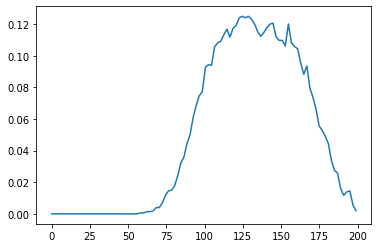

In [13]:
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep
)

In [14]:
bmi_information_gain_sweep = []
bmi_thresholds = np.linspace(diabetes.BMI.min(), diabetes.BMI.max(), 100)
for threshold in bmi_thresholds:
    bmi_information_gain_sweep.append(entropy(diabetes.Outcome) - weighted_entropy(diabetes, "BMI", "Outcome", threshold))

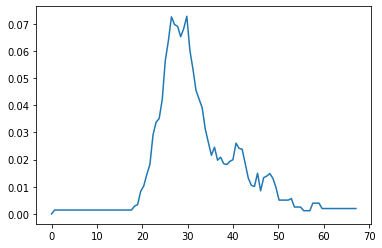

In [15]:
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep
)

Text(0.5, 0, 'threshold')

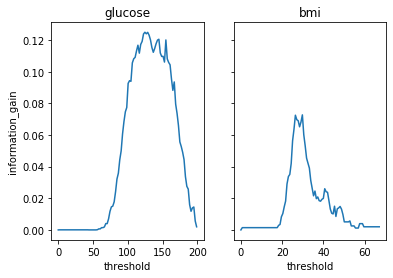

In [16]:
fig, axs = plt.subplots(nrows=1,ncols=2, sharey=True)
sns.lineplot(
    x = glucose_thresholds,
    y = glucose_information_gain_sweep,
    ax = axs[0]
)
sns.lineplot(
    x = bmi_thresholds,
    y = bmi_information_gain_sweep,
    ax = axs[1]
)
axs[0].set_title("glucose")
axs[1].set_title("bmi")
axs[0].set_ylabel("information_gain")
axs[0].set_xlabel("threshold")
axs[1].set_xlabel("threshold")

Seleccionamos el umbral que nos aporta la mayor ganancia de información.

In [17]:
optimal_glucose_threshold = glucose_thresholds[np.argmax(glucose_information_gain_sweep)]
optimal_glucose_threshold

124.62626262626262

In [18]:
entropy(diabetes.Outcome[diabetes.Glucose >= optimal_glucose_threshold])

0.9773203829731114

In [19]:
entropy(diabetes.Outcome[diabetes.Glucose < optimal_glucose_threshold])

0.6930190480473644

Utilizamos la implementación del árbol de decisión de sklearn para calcular la misma decisión.

In [20]:
single_decision = sklearn.tree.DecisionTreeClassifier(max_depth=1, criterion = "entropy")
single_decision = single_decision.fit(diabetes[["Glucose", "BMI"]], diabetes.Outcome)

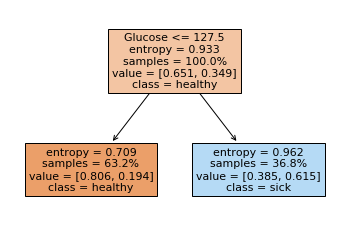

In [21]:
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    single_decision, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = ["Glucose", "BMI"], # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Preparamos el conjunto de datos para poder ajustar un árbol de decisión de mayor profundidad.

In [22]:
diabetes_features = diabetes.iloc[:,:-1]
diabetes_label = diabetes.Outcome

In [23]:
(
    diabetes_features_train, 
    diabetes_features_test, 
    diabetes_label_train, 
    diabetes_label_test
) = sklearn.model_selection.train_test_split(
    diabetes_features, 
    diabetes_label, 
    test_size=0.33, 
    random_state=11
)

In [24]:
tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
    max_depth=3, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
    criterion = "entropy"
    )
tree.fit( # Ajustamos nuestro árbol de decisión.
    diabetes_features_train,
    diabetes_label_train
)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Calculamos el rendimiento de nuestro árbol de decisión.

In [25]:
print(sklearn.metrics.classification_report(
    diabetes_label_test,
    tree.predict(diabetes_features_test)
))

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       165
           1       0.65      0.45      0.53        89

    accuracy                           0.72       254
   macro avg       0.69      0.66      0.67       254
weighted avg       0.71      0.72      0.71       254



Visualizamos el árbol de decisión.

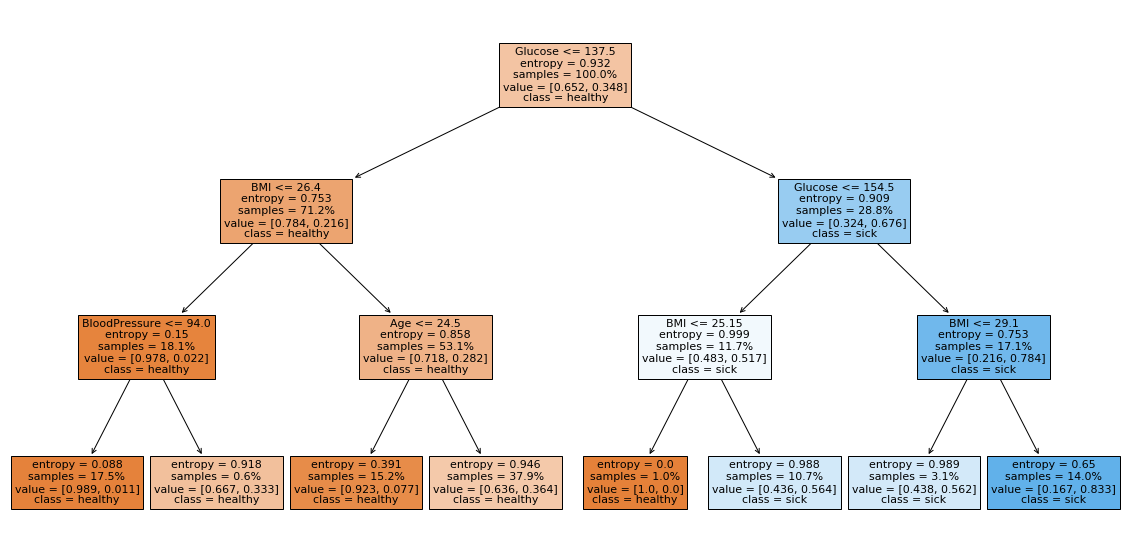

In [26]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.
)
plt.show()

Un hiperparámetro que podemos ajustar en un árbol de decisión es la profundidad máxima. Visualizamos que tenemos un mejoramiento inicial del rendimiento al aumentar la profundidad, para después descender debido al sobreajuste.

In [27]:
depths = range(1,10)
performances = []
for depth in depths:
    current_tree = sklearn.tree.DecisionTreeClassifier( # Instanciamos nuestro árbol de decisión.
        max_depth=depth, # Forzamos que nuestro árbol sólo tenga 3 niveles de profundidad.
        criterion = "entropy"
    )
    roc_auc = sklearn.model_selection.cross_val_score(
          current_tree,
          diabetes_features, 
          diabetes_label,
          scoring="roc_auc"
      ).mean()
    performances.append(roc_auc)

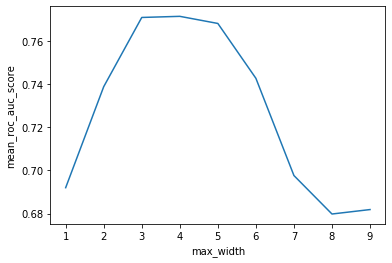

In [28]:
plt.plot(
    depths,
    performances
)
plt.xlabel("max_width")
plt.ylabel("mean_roc_auc_score")
plt.show()

## Random forests

En Random Forest, cada árbol en el conjunto está construido desde una muestra independiente del conjunto de entrenamiento, lo cual nos genera un conjunto de árboles no correlacionados. Esto se basa en la hipótesis de que si se tienen estimadores débiles que se combinan, la estimación final será más robusta que los estimadores unitarios.

In [29]:
random_forest = sklearn.ensemble.RandomForestClassifier(random_state = 11) # Instanciamos Random Forest.
random_forest.fit( # Ajustamos nuestro modelo.
    diabetes_features_train,
    diabetes_label_train
)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

Vemos que el rendimiento aumentó al utilizar este método.

In [30]:
print(sklearn.metrics.classification_report(
    diabetes_label_test,
    random_forest.predict(diabetes_features_test)
))

              precision    recall  f1-score   support

           0       0.78      0.92      0.84       165
           1       0.77      0.53      0.63        89

    accuracy                           0.78       254
   macro avg       0.78      0.72      0.74       254
weighted avg       0.78      0.78      0.77       254



Una de la información de inferencia que podemos extraer desde nuesto modelo entrenado es la lista de importancia de características, con la cual podemos conocer qué características son más importantes para el modelo.

In [31]:
feature_importance_list = pd.DataFrame(
    zip(diabetes.columns, 
        random_forest.feature_importances_), # En este atributo está almacenada la lista de importancia de características.
    columns=["feature","importance"])
feature_importance_list.sort_values("importance",ascending=False)

,feature,importance
1,Glucose,0.249526
5,BMI,0.154650
6,DiabetesPedigreeFunction,0.139635
7,Age,0.134451
2,BloodPressure,0.092810
0,Pregnancies,0.084016
3,SkinThickness,0.074679
4,Insulin,0.070234


Random Forest es un conjunto de árboles de decisión independientes, por lo podemos extraer uno de ellos y explorarlo directamente.

In [32]:
random_tree = random_forest.estimators_[-1]
random_tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1389577121, splitter='best')

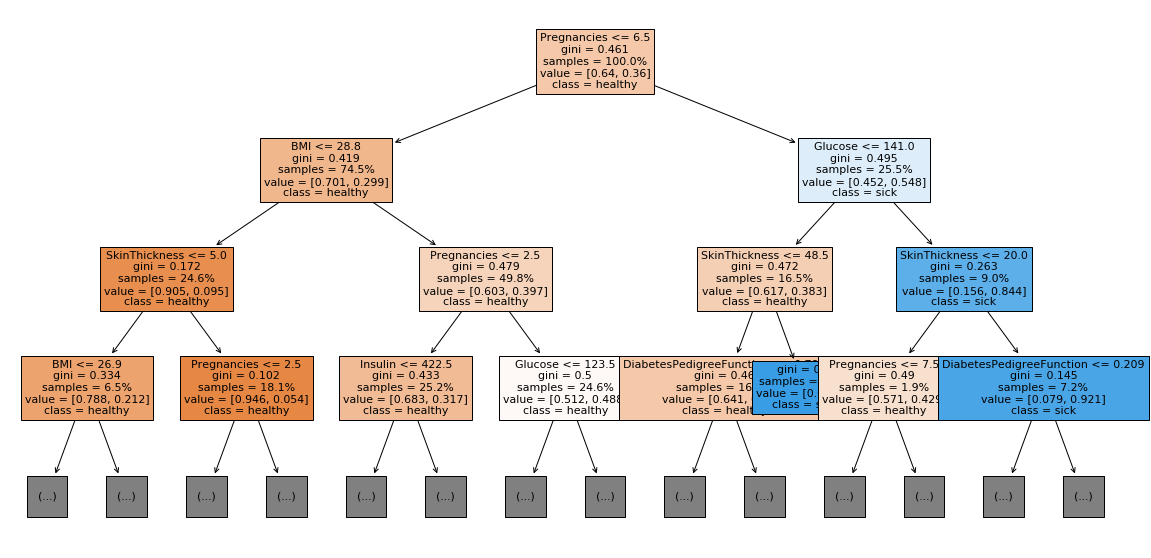

In [33]:
plt.figure(figsize = (20,10))
sklearn.tree.plot_tree( # Función que nos permite visualizar el árbol de decisión ajustado.
    random_tree, # Objeto de nuestro árbol de decisión entrenado.
    feature_names = diabetes_features.columns, # Nombres de las variables utilizadas para entrenar.
    class_names = ["healthy","sick"], # Nombre de las clases que estamos prediciendo.
    label = "all", # Etiquetamos todas características de cada nodo.
    proportion = True, # Visualizamos las proporciones de datos en cada nodo de decisión,
    filled=True, # Coloreamos los nodos
    fontsize=11, # Establecemos el tamaño de la letra del texto dentro de cada nodo.,
    max_depth=3 # Profundidad máxima del árbol
)
plt.show()